## 语义分割和数据集
    在这个章节使用PascalVOC2012数据集作为实例

In [38]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as T
from torch.nn import functional as F

- 下载PascaVoc数据集

In [3]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [4]:
voc_dir

'..\\data\\VOCdevkit/VOC2012'

- 读取VOC数据集

In [65]:
def read_voc_images(voc_dir, is_train=True):
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    mode = torchvision.io.image.ImageReadMode.RGB
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(
            os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
        ))
        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'), mode
            )
        )
    return features, labels
train_features, train_labels = read_voc_images(voc_dir, True)
len(train_features)

1464

- 在VOC数据集中，要精确到每个像素点是什么，所以对于一张图片来说，这个图片的标签是一张大小相同的图片

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

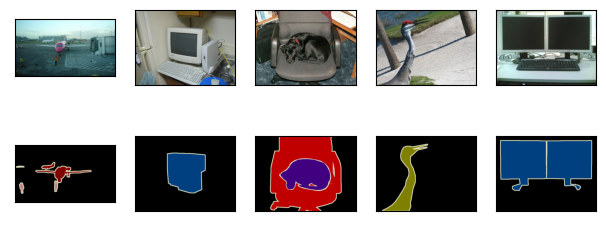

In [15]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

- `VOC_COLORMAP`是VOC数据集的COLORMAP，对应的rgb值与`VOC_CLASSES`中的类别名一一对应

In [21]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

- 但是我们不需要标签是字母，而是需要标签是数字，所以我们要为每一类标签建立一个到标号（数字）的映射，把RGB值转为类别

In [26]:
def voc_colormap2label():
    """构建从RGB值到类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2] 
        ] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """
    将VOC标签中的RGB值映射到他们的类别索引
    colormap: 图片的标签
    colormap2label: RGB值到类别的索引表
    """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [27]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 数据预处理
- 在语义分割中，我们一般都是从原始数据集中裁剪对应大小的图片，而不是去做拉伸，压缩等操作，因为这些操作一般都要伴随着插值操作进行，而插值操作会影响图片label的RGB值导致插值的RGB值不属于任何一个类别

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

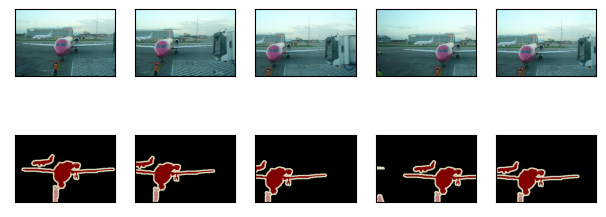

In [60]:
import torchvision.transforms.functional


def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = T.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

### 实现自定义VOC数据集

In [66]:
class VOCSegDataset(Dataset):
    """自定义PascalVOC数据集用于语义分割"""
    def __init__(self, is_train, crop_size, voc_dir):
        super().__init__()
        self.transform = T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
    
    def normalize_image(self, image):
        return self.transform(image.float() / 255)
    
    def filter(self, imgs):
        return [img for img in imgs if img.shape[1] >= self.crop_size[0]
                and img.shape[2] >= self.crop_size[1]]
    
    def __getitem__(self, index):
        feature, label = voc_rand_crop(self.features[index], self.labels[index], 
                                       *self.crop_size)
        return feature, voc_label_indices(label, self.colormap2label)
    
    def __len__(self):
        return len(self.features)
    
voc_dir

'..\\data\\VOCdevkit/VOC2012'

In [67]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


- 加载dataloader

In [68]:
batch_size = 64
train_iter = DataLoader(voc_train, batch_size, shuffle=True, 
                        drop_last=True, 
                        num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

: 

: 

- 整合所有组件，加载VOC数据集

In [ ]:
def load_data_voc(batch_size, crop_size):
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = DataLoader(VOCSegDataset(True, crop_size, voc_dir), 
                            batch_size, shuffle=True, drop_last=True,
                            num_workers=num_workers)
    test_iter = DataLoader(VOCSegDataset(False, crop_size, voc_dir),
                           batch_size, drop_last=True, num_workers=num_workers)
    return train_iter, test_iter